In [1]:
import torch
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.training.configs.training_configs import ProcessDatasetConfig
from epsilon_transformers.process.processes import Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from pathlib import Path
import json

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoint_path = Path("/workspaces/cure/compmech-models/models/f6gnm1we-mess3-0.15-0.6/")
weights = torch.load(checkpoint_path / "998406400.pt")

with open(checkpoint_path / "train_config.json", "r") as f:
    required_fields = ['d_vocab', 'd_model', 'n_ctx', 'd_head', 'n_heads', 'n_layers']
    cfg_dict = {k: v for k, v in json.load(f).items() if k in required_fields}
    cfg_dict['n_head'] = cfg_dict.pop('n_heads')
    cfg_dict['d_mlp'] = 4 * cfg_dict['d_model']
    train_config = RawModelConfig(**cfg_dict)

model = train_config.to_hooked_transformer(device=torch.device("cuda"))
model.load_state_dict(weights)

<All keys matched successfully>

Import MSP tree and generate all possible paths.

In [3]:
mess3 = Mess3()
msp_tree = mess3.derive_mixed_state_presentation(depth=model.cfg.n_ctx + 1)
tree_paths, tree_beliefs = msp_tree.paths_and_belief_states

transformer_inputs = [x for x in tree_paths if len(x) == train_config.n_ctx]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to("cuda:0")

Cache transformer beliefs (~2 min on GPU).

In [4]:
# msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
# msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}
# optimal_transformer_input_beliefs, optimal_transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs, msp_belief_index, tree_paths, tree_beliefs)


In [5]:
from transformer_lens.hook_points import HookPoint
from torch.optim import Adam, Optimizer
from torch import nn
import numpy as np
from functools import partial


In [106]:
torch.set_default_device("cuda")

class CorrelationDimensionLoss(nn.Module):
    def __init__(self, r_values, k=10):
        super(CorrelationDimensionLoss, self).__init__()
        self.r_values = torch.tensor(r_values, dtype=torch.float32)
        self.k = k

    def forward(self, points):
        distances = torch.cdist(points, points, p=2)
        distances = distances.triu(diagonal=1)
        distances = distances[distances > 0]

        correlation_sums = []
        for r in self.r_values:
            smooth_heaviside = torch.sigmoid(self.k * (r - distances))
            correlation_sum = smooth_heaviside.mean()
            correlation_sums.append(correlation_sum)
        
        correlation_sums = torch.stack(correlation_sums)
        log_r = torch.log(self.r_values)
        log_c = torch.log(correlation_sums)

        # Perform linear regression on log-log values
        A = torch.stack([log_r, torch.ones_like(log_r)], dim=1)
        slope, intercept = torch.linalg.lstsq(A, log_c).solution

        correlation_dimension = slope#.item()
        
        return -correlation_dimension

class DifferentiableBoxCountingDimensionLoss(nn.Module):
    def __init__(self, epsilons, sigma=0.1, spread_weight=0.1):
        super(DifferentiableBoxCountingDimensionLoss, self).__init__()
        self.epsilons = torch.tensor(epsilons, dtype=torch.float32)
        self.sigma = sigma
        self.spread_weight = spread_weight

    def forward(self, points):
        batch_size, num_points, dim = points.size()
        counts = []

        for epsilon in self.epsilons:
            # Scale points to fit in unit cube
            scaled_points = points / epsilon

            # Create a Gaussian kernel to approximate box occupancy
            diff = scaled_points.unsqueeze(2) - scaled_points.unsqueeze(1)
            dist = torch.exp(-torch.sum(diff**2, dim=-1) / (2 * self.sigma**2))
            occupancy = dist.mean(dim=2)

            # Approximate number of occupied boxes
            count = torch.sum(occupancy, dim=1).mean()
            counts.append(count)

        counts = torch.stack(counts)
        log_epsilon = torch.log(self.epsilons)
        log_counts = torch.log(counts)

        # Perform linear regression on log-log values
        A = torch.stack([log_epsilon, torch.ones_like(log_epsilon)], dim=1)
        slope, intercept = torch.linalg.lstsq(A, log_counts).solution

        fractal_dimension = slope

        # Spread/Diversity term to avoid point collapse
        pairwise_distances = torch.cdist(points, points, p=1)
        spread_term = torch.mean(pairwise_distances)

        # Total loss
        total_loss = fractal_dimension - self.spread_weight * spread_term
        
        return total_loss

In [112]:
class LinearProbe(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, dtype=torch.float32)
    def forward(self, residual_stream: torch.Tensor):
        x = torch.softmax(self.linear(residual_stream), dim=2)
        return x

lr = 1e-3
logspace_min = -4
logspace_max = 0
logspace_num = 50
sigma = 0.1
num_iters = 10
batch_size = 1024
spread_weight=0.1

linear_probe = LinearProbe(64, 3).cuda()
optimizer = Adam(linear_probe.parameters(), lr=lr)

r_values = np.logspace(logspace_min, logspace_max, num=logspace_num)
# loss_fn = CorrelationDimensionLoss(r_values)
loss_fn = DifferentiableBoxCountingDimensionLoss(epsilons=r_values, sigma=sigma, spread_weight=spread_weight)

def probe_train_hook(attn_result: torch.Tensor, hook: HookPoint) -> torch.Tensor:
    optimizer.zero_grad()
    probe_out = linear_probe(attn_result)
    loss = loss_fn(probe_out)
    loss.backward()
    optimizer.step()
    print(loss)
    return attn_result

In [113]:
model.eval()
transformer_inputs.to("cuda")
linear_probe.to("cuda")
transformer_input_loader = torch.utils.data.DataLoader(transformer_inputs, batch_size=batch_size)

for i in range(num_iters):
    print(i)
    for transformer_input in transformer_input_loader:
        _ = model.run_with_hooks(transformer_input, fwd_hooks=[('blocks.3.hook_resid_post', probe_train_hook)])
        # print(linear_probe(transformer_input[0]))

0
tensor(0.1960, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.1756, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.1479, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.1233, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.1044, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0821, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0669, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0582, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0430, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0293, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0233, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0165, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0113, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0068, device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-0.0009, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-0.0016, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-0.0047, device='cuda:0', grad_fn=<Su

In [114]:
from typing import List
def probe_log_hook(attn_result: torch.Tensor, hook: HookPoint, belief_guess_list: List) -> torch.Tensor:
    probe_out = linear_probe(attn_result)
    belief_guess_list.append(probe_out)
    return attn_result

belief_guess_list = []
for transformer_input in transformer_input_loader:
    hook_with_beliefs = partial(probe_log_hook, belief_guess_list=belief_guess_list)
    _ = model.run_with_hooks(transformer_input, fwd_hooks=[('blocks.3.hook_resid_post', hook_with_beliefs)])
    break

points = torch.cat(belief_guess_list)
points = points.view(points.shape[0]*points.shape[1], points.shape[2])

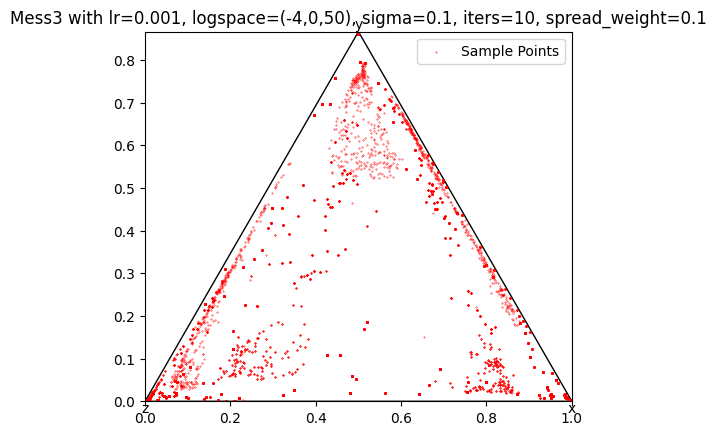

In [115]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to convert ternary coordinates to Cartesian coordinates
def ternary_to_cartesian(triples):
    points = []
    for triple in triples:
        x = 0.5 * (2 * triple[1] + triple[2])
        y = (np.sqrt(3) / 2) * triple[2]
        points.append([x, y])
    return np.array(points)

# Convert ternary coordinates to Cartesian coordinates
ternary_points = ternary_to_cartesian(points.cpu().detach().numpy())

# Plotting
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 1)
ax.set_ylim(0, np.sqrt(3) / 2)

# Draw the triangle
triangle = plt.Polygon([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]], edgecolor='k', fill=None)
ax.add_patch(triangle)

# Plot points
ax.scatter(ternary_points[:, 0], ternary_points[:, 1], color='red', label='Sample Points',s=0.1)

# Add labels
ax.text(0, 0, 'z', ha='center', va='top')
ax.text(1, 0, 'x', ha='center', va='top')
ax.text(0.5, np.sqrt(3) / 2, 'y', ha='center', va='bottom')

# Show plot
plt.title(f"Mess3 with lr={lr}, logspace=({logspace_min},{logspace_max},{logspace_num}), sigma={sigma}, iters={num_iters}, spread_weight={spread_weight}")
plt.legend()
plt.show()


In [116]:
points

tensor([[0.0031, 0.0030, 0.9939],
        [0.0259, 0.0578, 0.9162],
        [0.2647, 0.6487, 0.0866],
        ...,
        [0.9485, 0.0300, 0.0215],
        [0.6189, 0.2627, 0.1184],
        [0.0147, 0.6836, 0.3017]], device='cuda:0', grad_fn=<ViewBackward0>)